# GATE (Deep Image Prior)

This tutorial demonstrates how to use the Deep Image Prior Reconstruction algorithm (`DIPRecon`) to reconstruction PET data using the MRI image as the prior image. In this case, we'll use listmode time-of-flight reconstruciton.

* This notebook requires `monai` to be installed

In [1]:
import torch
import torch.nn as nn
from torch.optim import LBFGS
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta, PETTOFMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, DIPRecon
from pytomography.io.PET import gate
from pytomography.likelihoods import PoissonLogLikelihood
from pytomography.transforms.shared import GaussianFilter
from pytomography.utils import sss
import matplotlib.pyplot as plt
import gc
import os
import numpy as np
import numpy as np
from monai.transforms import ScaleIntensityd, CropForeground, Compose, DivisiblePadd, SpatialCropd, ThresholdIntensityd


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_c.so.1.8.0
    parallelproj CUDA lib: /data/anaconda/envs/pytomo_install_test/lib/libparallelproj_cuda.so.1.8.0
    


The Deep Image Prior requires an initial reconstructed image using a standard reconstruction algorithm like OSEM. The code below is a summary of everything in the GATE listmode-TOF tutorial. (It also assumes that the raw data has already been saved to tensor format)

In [2]:
path = '/disk1/pet_mri_scan/'
# Macro path where PET scanner geometry file is defined
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Get information dictionary about the scanner
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)

In [3]:
path = '/disk1/pet_mri_scan/'
# Macro path where PET scanner geometry file is defined
macro_path = os.path.join(path, 'mMR_Geometry.mac')
# Get information dictionary about the scanner
info = gate.get_detector_info(path = macro_path,
    mean_interaction_depth=9, min_rsector_difference=0)
# Paths to all ROOT files containing data
paths = [os.path.join(path, f'gate_simulation/all_physics/mMR_voxBrain_{i}.root') for i in range(1, 55)]; del(paths[23]) #path 23 corrupted

speed_of_light = 0.3 #mm/ps
fwhm_tof_resolution = 550 * speed_of_light / 2 #ps to position along LOR
TOF_range = 1000 * speed_of_light #ps to position along LOR (full range)
num_tof_bins = 5
tof_meta = PETTOFMeta(num_tof_bins, TOF_range, fwhm_tof_resolution, n_sigmas=3)

normalization_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))
detector_ids = torch.load(os.path.join(path, 'detector_ids_tof_all_events.pt'))
detector_ids_delays= torch.load(os.path.join(path, 'detector_ids_delays.pt'))

sinogram_randoms_estimate = gate.listmode_to_sinogram(
    detector_ids_delays,
    info
)
sinogram_randoms_estimate = gate.smooth_randoms_sinogram(
    sinogram_randoms_estimate,
    info,
    sigma_r=4,
    sigma_theta=4,
    sigma_z=4
)
sinogram_randoms_estimate = gate.randoms_sinogram_to_sinogramTOF(
    sinogram_randoms_estimate,
    tof_meta = tof_meta,
    coincidence_timing_width = 4300
) # coinicidence timing window for this GATE simulation was set to 4300ps
lm_randoms_estimate = gate.sinogram_to_listmode(
    detector_ids,
    sinogram_randoms_estimate,
    info,
)

object_meta = ObjectMeta(
    dr=(1.25,1.25,1.25), #mm
    shape=(204,204,154) #voxels
)
# Get projection space metadata from PET geometry information dictionary
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    tof_meta=tof_meta,
    weights_sensitivity=normalization_weights
    )
atten_map = gate.get_attenuation_map_nifti('/disk1/pet_mri_scan/fdg_pet_phantom_umap.nii.gz', object_meta)
normalization_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))
proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    weights_sensitivity=normalization_weights,
    tof_meta=tof_meta
    )
psf_transform = GaussianFilter(4)
system_matrix = PETLMSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       N_splits=10,
       attenuation_map=atten_map.to(pytomography.device),
)
lm_norm = system_matrix._compute_sensitivity_projection(all_ids=False)
additive_term = lm_randoms_estimate / lm_norm
additive_term[additive_term.isnan()] = 0 # remove NaN values
# Provide the random-only 
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_without_scatter_estimation = recon_algorithm(50,1)

# Scatter correction
scatter_sinogram = sss.get_sss_scatter_estimate(
        object_meta,
        proj_meta,
        recon_without_scatter_estimation,
        atten_map,
        system_matrix,
        sinogram_random=sinogram_randoms_estimate,
        tof_meta=tof_meta,
        num_dense_tof_bins=25,
        image_stepsize=8)
lm_scatter_estimate = gate.sinogram_to_listmode(proj_meta.detector_ids, scatter_sinogram, proj_meta.info)
# Save memory, these are not needed anymore
del(system_matrix)
del(likelihood)
del(scatter_sinogram)
del(sinogram_randoms_estimate)
gc.collect()

# System matrix with no PSF modeling
system_matrix = PETLMSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [],
       N_splits=10,
       attenuation_map=atten_map.to(pytomography.device),
)
additive_term = (lm_scatter_estimate + lm_randoms_estimate) / lm_norm
additive_term[additive_term.isnan()] = 0
likelihood = PoissonLogLikelihood(
        system_matrix,
        additive_term = additive_term
    )
recon_algorithm = OSEM(likelihood)
recon_lm_tof = recon_algorithm(50,1)

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


In [4]:
filter = GaussianFilter(3)
filter.configure(object_meta, proj_meta)
recon_lm_tof_filtered = filter(recon_lm_tof)

The Deep Image Prior requires a neural network architecture that takes as input a 3D image (the prior image, in this case the MRI) and outputs a 3D image (the PET image). In this case, we'll define a simple UNet architecture (similar to the one in the DIPRecon paper) below:

* The UNet has 5 layers and reduces the object dimensions by a factor of 2 (but increases the number of channels) in each downward block.

In [5]:
def get_downward_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(), 
        ) 
    
def get_downsample_block(out_channels):
    return nn.Sequential(
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=2, padding=(1,1,1)),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
        ) 
    
def get_bottleneck_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(out_channels),
            nn.LeakyReLU(),
        ) 
    
def get_bilinear_upsample_block(in_channels, out_channels):
    return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True),
            nn.Conv3d(in_channels, out_channels, kernel_size=1, padding='same'),
        )
    
def get_upward_block(in_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(in_channels),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(in_channels),
            nn.LeakyReLU(),
        )
    
def get_final_block(in_channels):
    return nn.Sequential(
            nn.Conv3d(in_channels, in_channels, kernel_size=3, padding='same'),
            nn.BatchNorm3d(in_channels),
            nn.LeakyReLU(),
            nn.Conv3d(in_channels, 1, kernel_size=3, padding='same'),
        )
    
class UNetCustom(nn.Module):
    def __init__(self, n_channels=[4, 8, 16, 32, 64]):
        super().__init__()       
        self.downward_block1 = get_downward_block(1, n_channels[0])
        self.downward_block2 = get_downward_block(n_channels[0], n_channels[1])
        self.downward_block3 = get_downward_block(n_channels[1], n_channels[2])
        self.downward_block4 = get_downward_block(n_channels[2], n_channels[3])
        self.downsample_block1 = get_downsample_block(n_channels[0])
        self.downsample_block2 = get_downsample_block(n_channels[1])
        self.downsample_block3 = get_downsample_block(n_channels[2])
        self.downsample_block4 = get_downsample_block(n_channels[3])
        self.bottleneck_block = get_bottleneck_block(n_channels[3], n_channels[4])
        self.upsample_block1 = get_bilinear_upsample_block(n_channels[4], n_channels[3])
        self.upsample_block2 = get_bilinear_upsample_block(n_channels[3], n_channels[2])
        self.upsample_block3 = get_bilinear_upsample_block(n_channels[2], n_channels[1])
        self.upsample_block4 = get_bilinear_upsample_block(n_channels[1], n_channels[0])
        self.upward_block1 = get_upward_block(n_channels[3])
        self.upward_block2 = get_upward_block(n_channels[2])
        self.upward_block3 = get_upward_block(n_channels[1])
        self.final_block = get_final_block(n_channels[0])
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.downward_block1(x)
        x = self.downsample_block1(x1)
        x2 = self.downward_block2(x)
        x = self.downsample_block2(x2)
        x3 = self.downward_block3(x)
        x = self.downsample_block3(x3)
        x4 = self.downward_block4(x)
        x = self.downsample_block4(x4)
        x = self.bottleneck_block(x)
        x = self.upsample_block1(x) + x4
        x = self.upward_block1(x)
        x = self.upsample_block2(x) + x3
        x = self.upward_block2(x)
        x = self.upsample_block3(x) + x2
        x = self.upward_block3(x)
        x = self.upsample_block4(x) + x1
        x = self.final_block(x)
        return x

Note that this network actually expects a 5D image of shape `[batch_size, n_channels, Lx, Ly, Lz]`, so we need to take this into account.

In [6]:
test_input = torch.ones((1,1,128,128,128))
test_output = UNetCustom()(test_input)
print(test_input.shape)
print(test_output.shape)

torch.Size([1, 1, 128, 128, 128])
torch.Size([1, 1, 128, 128, 128])


The next thing the DIP Prior needs is a class that implements a `fit` and `predict` method. The `fit` method should take in an object (the PET image in this case) and update the neural networks weights. The `predict` method should yield the current prediction of the neural network. In PyTomography, this is left very general and up to the user to allow for more flexibility in experimentation (feel free to grab this code though).

In [7]:
class DIPPrior():
    def __init__(
        self,
        network,
        anatomical_image,
        pipeline, # pipeline for preprocessing MRI image
        scale_factor=1, # constant to scale MRI image by
        n_epochs=10, # how many epochs the network trains for when fitting
        lr = 0.1, # learning rate when fitting
    ):
        self.network = network
        self.anatomical_image = anatomical_image
        self.pipeline = pipeline
        self.n_epochs = n_epochs
        self.scale_factor = scale_factor
        self.lr = lr
        self.max_iter = 20
        
    def fit(self, object):
        # This method trains the network for n_epochs at a learning rate of lr
        data = self.pipeline({'NM': object.unsqueeze(0), 'MR': self.anatomical_image.unsqueeze(0)})
        optimizer_lfbgs = LBFGS(self.network.parameters(), lr=self.lr, max_iter=self.max_iter, history_size=100)
        NM_truth = data['NM'].unsqueeze(0) * self.scale_factor
        network_input = data['MR'].unsqueeze(0)
        criterion = torch.nn.MSELoss()
        def closure(optimizer):
            optimizer.zero_grad()
            NM_prediction = self.network(network_input)
            loss = criterion(NM_prediction, NM_truth)
            loss.backward()
            return loss
        for epoch in range(self.n_epochs):  
            loss = optimizer_lfbgs.step(lambda: closure(optimizer_lfbgs))
        self.network.zero_grad(set_to_none=True)
        with torch.no_grad():
            # Add batch/channel dimension
            network_prediction = self.network(data['MR'].unsqueeze(0)).squeeze()
        self.prior_object = self.pipeline.inverse({'NM': network_prediction.unsqueeze(0)})['NM'].as_tensor().squeeze() / self.scale_factor
        
    def predict(self):        
        return self.prior_object.detach()

In [8]:
import nibabel as nib
import numpy.linalg as npl 
from scipy.ndimage import affine_transform
def align_highres_image(path, img=None):
    # If img is none, extract data from path
    data = nib.load(path)
    # If img is none, extract data from path
    if img is None:
        img = data.get_fdata()
    Sx, Sy, Sz = -(np.array(img.shape)-1) / 2
    dx, dy, dz = data.header['pixdim'][1:4]
    # Convert from RAS to LPS space for DICOM
    dx*=-1; dy*=-1
    M_highres = np.zeros((4,4))
    M_highres[0] = np.array([dx, 0, 0, Sx*dx])
    M_highres[1] = np.array([0, dy, 0, Sy*dy])
    M_highres[2] = np.array([0, 0, dz, Sz*dz])
    M_highres[3] = np.array([0, 0, 0, 1])
    dx, dy, dz = object_meta.dr
    Sx, Sy, Sz = -(np.array(object_meta.shape)-1) / 2
    M_pet = np.zeros((4,4))
    M_pet[0] = np.array([dx, 0, 0, Sx*dx])
    M_pet[1] = np.array([0, dy, 0, Sy*dy])
    M_pet[2] = np.array([0, 0, dz, Sz*dz])
    M_pet[3] = np.array([0, 0, 0, 1])
    M = npl.inv(M_highres) @ M_pet
    return affine_transform(img, M, output_shape=object_meta.shape, mode='constant', order=1)
mri_aligned = torch.tensor(align_highres_image('/disk1/pet_mri_scan/fdg_pet_phantom_mri.nii.gz')).to(pytomography.device).to(torch.float32)

The pipeline for preprocessing the MRI/PET image in the neural network is defined below. Understanding this code requires familiarity with MONAI

In [9]:
# mri_aligned = torch.tensor(np.load('/disk1/pet_dip_recon/mri_aligned.npy')).to(pytomography.device)

mri_crop_above = 250
mri_crop_below = 120

roi_start, roi_end = CropForeground().compute_bounding_box(mri_aligned.unsqueeze(0))
pipeline = Compose([
    SpatialCropd(['MR', 'NM'], roi_start=roi_start, roi_end=roi_end, allow_missing_keys=True),
    DivisiblePadd(['MR', 'NM'], 16, allow_missing_keys=True),
    ThresholdIntensityd(['MR'], mri_crop_above, above=False, cval=mri_crop_above),
    ThresholdIntensityd(['MR'], mri_crop_below, above=True, cval=mri_crop_below),
    ScaleIntensityd(['MR'], 0, 1)
])

monai.transforms.croppad.array CropForeground.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


Now lets create our DIP prior using our initialized network and pipeline:

In [10]:
start_channels = 12
net = UNetCustom([start_channels,2*start_channels,4*start_channels,8*start_channels,16*start_channels]).to(pytomography.device)

In [11]:
dip_prior = DIPPrior(
    net,
    mri_aligned,
    pipeline,
    n_epochs= 100,
    scale_factor= 50,
    lr=0.01
    )

Before we use the DIPRecon reconstruction algorithm, we first need to pretrain our network on the initial reconstructed PET image

In [12]:
dip_prior.fit(recon_lm_tof)

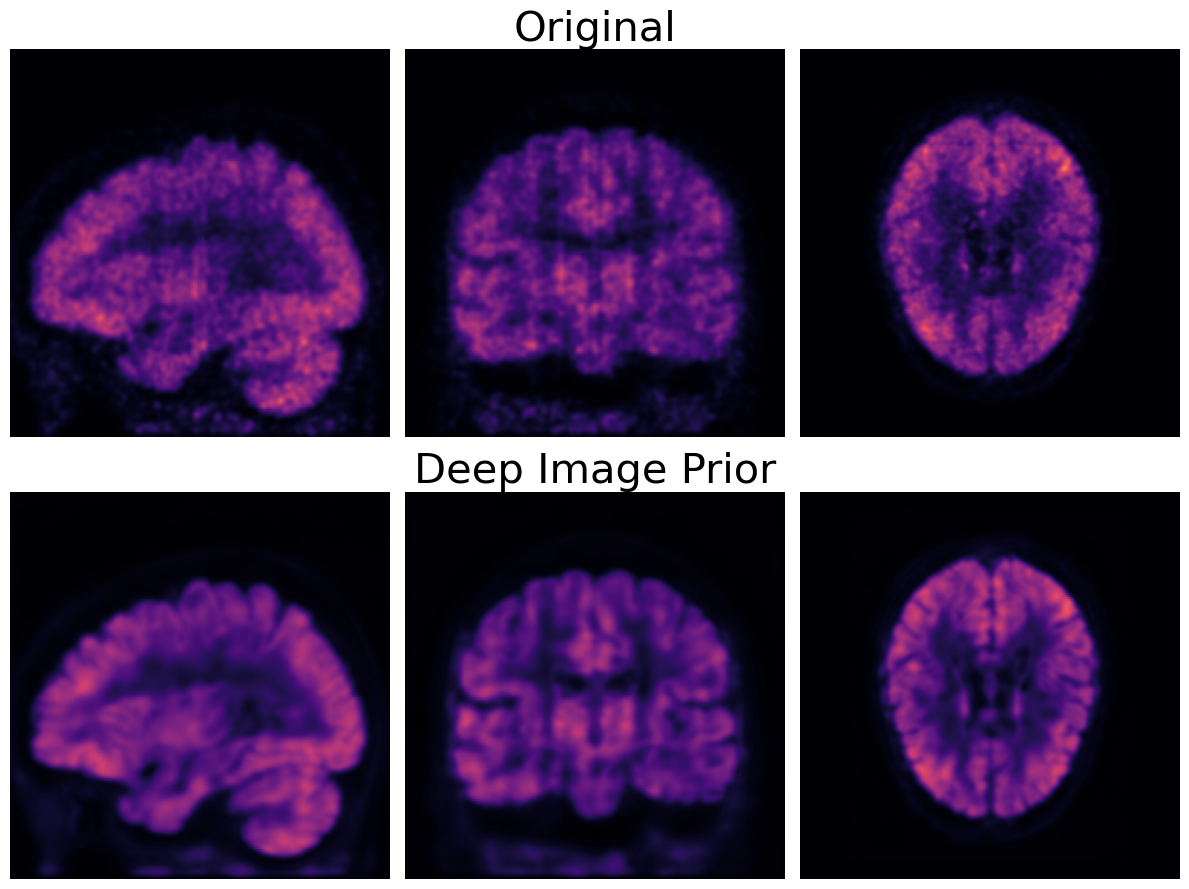

In [13]:
vmax = 0.15
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_lm_tof_filtered[77,25:-25].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_lm_tof_filtered[25:-25,103].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.title('Original', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_lm_tof_filtered[:,:,77].cpu().T, cmap='magma', vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(dip_prior.prior_object[77,25:-25].detach().cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(dip_prior.prior_object[25:-25,103].detach().cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
plt.title('Deep Image Prior', fontsize=30)
plt.subplot(236)
plt.pcolormesh(dip_prior.prior_object[:,:,77].detach().cpu().T, cmap='magma', shading='gouraud', vmax=vmax)
plt.axis('off')
fig.tight_layout()
plt.show()

Now we'll adjust the `DIPPrior` parameters for our final reconstruction

In [14]:
dip_prior.n_epochs = 10
dip_prior.max_iter = 20
dip_prior.lr = 1

Finally, we can reconstruct using the `DIPRecon` reconstruction algorithm. The parameters `rho` scales the weighting between regular EM updates and the DIP Prior (high `rho` means more weight to the prior)

In [15]:
recon_algorithm = DIPRecon(
    likelihood = likelihood,
    prior_network=dip_prior,
    rho=5e5,
)

In [16]:
recon_DIP = recon_algorithm(n_iters=100, subit1=2)

And we can compare to the original

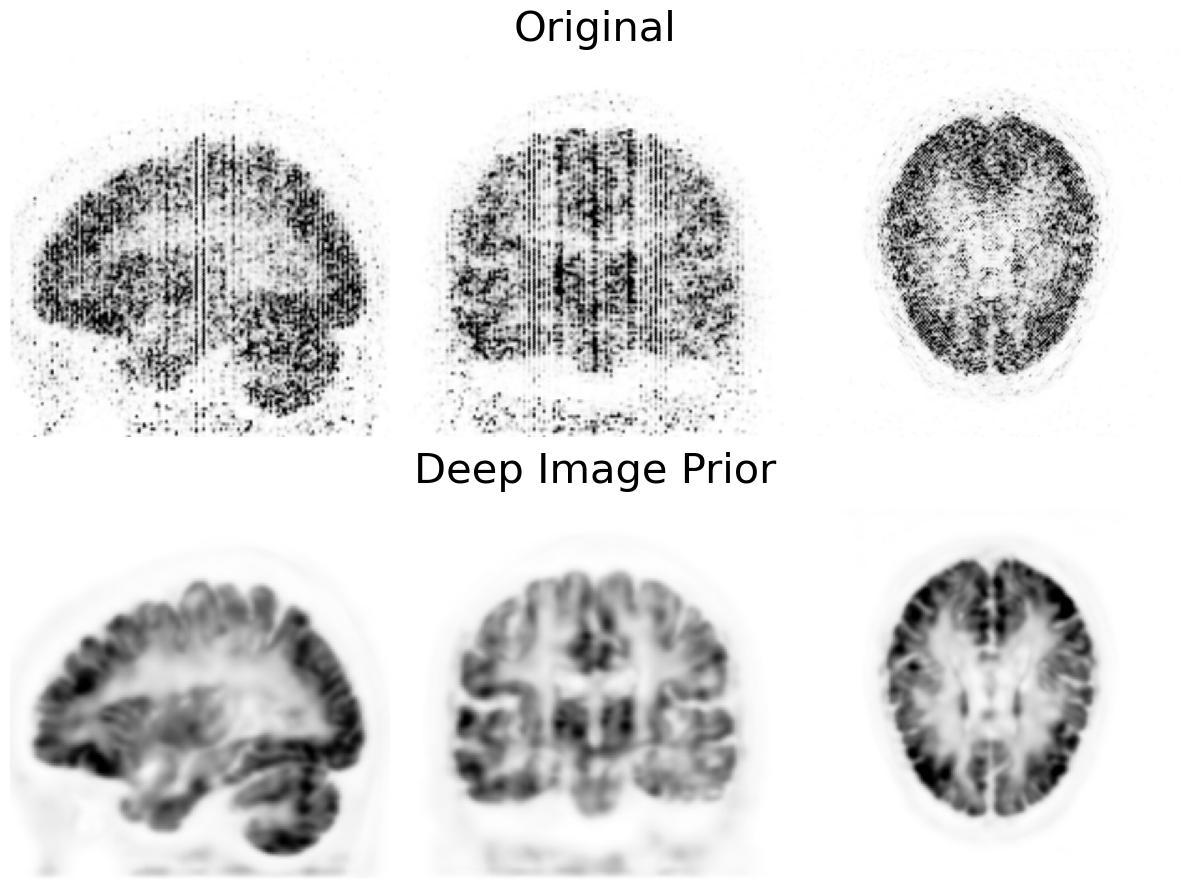

In [17]:
vmax = 0.08
cmap = 'Greys'
fig, ax = plt.subplots(2,3,figsize=(12,9))
plt.subplot(231)
plt.pcolormesh(recon_lm_tof[77,25:-25].cpu().T, cmap=cmap, vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(232)
plt.pcolormesh(recon_lm_tof[25:-25,103].cpu().T, cmap=cmap, vmax=vmax, shading='gouraud')
plt.title('Original', fontsize=30)
plt.axis('off')
plt.subplot(233)
plt.pcolormesh(recon_lm_tof[:,:,77].cpu().T, cmap=cmap, vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(234)
plt.pcolormesh(recon_DIP[77,25:-25].cpu().T, cmap=cmap, vmax=vmax, shading='gouraud')
plt.axis('off')
plt.subplot(235)
plt.pcolormesh(recon_DIP[25:-25,103].cpu().T, cmap=cmap, vmax=vmax, shading='gouraud')
plt.axis('off')
plt.title('Deep Image Prior', fontsize=30)
plt.subplot(236)
plt.pcolormesh(recon_DIP[:,:,77].cpu().T, cmap=cmap, vmax=vmax, shading='gouraud')
plt.axis('off')
fig.tight_layout()
plt.show()

The Deep Image Prior image is smoothed relative to the original; it may take more fine-tuning to get better results.